In [1]:
import argparse
import torch
import numpy as np
import matplotlib.pyplot as plt

import pyvista as pv

# Local import from repo
import ssmaginv.magnetics.magneticsFP as mg

### Generate True Mag Susceptibility Model

In [2]:
def gen_true_data(dim):

    # set the magnetization model
    xtrue = torch.zeros(*dim)
    xtrue[30:50, 40:50, 10:20] = 0.6
    xtrue[20:40, 20:40, 5:15] = 0.2
    xtrue[10:15, 10:15, 2:5] = 0.5

    return xtrue

# Set the model parameters
n1 = 64
n2 = 64
n3 = 32
dim = torch.tensor([n1, n2, n3])
h = torch.tensor([100.0, 100.0, 100.0])
dirs = torch.tensor([np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2])

forMod = mg.Magnetics(dim, h, dirs)

# Generate a forward sample
xtrue = gen_true_data(dim).unsqueeze(0).unsqueeze(0) 
D = forMod(xtrue)
noise = torch.randn_like(D)
D = D + 0.001 * noise

### Generate a proposed solution to inverse problem

In [3]:
def conj_gradient(A, b, x0=None, niter=20, tol=1e-2, alpha=1e-2, verbose=True):
    """
    Solve Ax=b using the conjugate gradient method.

    Paramters:
        A (callable): A function that computes the operator Ax.
        b (torch.Tensor): The right-hand side vector.
        x0 (torch.Tensor, optional): The initial guess. Defaults to None.
        niter (int, optional): Maximum number of iterations. Defaults to 20.
        tol (float, optional): Tolerance for the residual. Defaults to 1e-2.
        alpha (float, optional): Step size for the conjugate gradient method. Defaults to 1e-2.
    """
    if x0 is None:
        r = b
    else:
        r = b - A(x0)

    q = r
    x = torch.zeros_like(b)
    for i in range(niter):
        Aq = A(q)
        alpha = (r * r).sum() / (q * Aq).sum()
        x = x + alpha * q
        rnew = r - alpha * Aq
        beta = (rnew**2).sum() / (r**2).sum()
        q = rnew + beta * q
        r = rnew.clone()
        if verbose:
            print("iter = %3d    res = %3.2e" % (i, r.norm() / b.norm()))
        if r.norm() / b.norm() < tol:
            break
    return x

def adjoint(A, v, x_sample):
    """
    Take the adjoint of the forward operator A with respect to the input vector v.

    Parameters:
        A (callable): Forward operator.
        v (torch.Tensor): Input vector.
        x_sample (torch.Tensor): Sample input for dimensioning (dummy data).
    """

    x = torch.zeros_like(x_sample)
    x.requires_grad = True
    b = A(x)
    # Compute the dot product of the forward operator with the input vector
    h = torch.sum(b * v)
    # Compute the gradient of the dot product with respect to the input image
    adjoint = torch.autograd.grad(h, x, create_graph=True)[0]
    return adjoint

def reg_gradx(x):
    gx = x[:, :, 1:, :, :] - x[:, :, :-1, :, :]
    gy = x[:, :, :, 1:, :] - x[:, :, :, :-1, :]
    gz = x[:, :, :, :, 1:] - x[:, :, :, :, :-1]
    # Concatenate the flattened gradients into a 1d vector together and return as the W(M) vector
    return torch.cat([torch.flatten(gx), torch.flatten(gy), torch.flatten(gz)])

def solve_ls(x0, D, forMod, reg_func = reg_gradx, alpha = 1e-6, ):
    """ 
    Least squares solution for the inverse problem forMod(x) = D
    with regularization and initial guess x0. Uses conjugate gradient method.
    """
    
    # Define the forward operator with regularization
    def A(x, alpha=alpha):
        y1 = forMod(x)
        y1 = forMod.adjoint(y1)
        y2 = reg_func(x)
        y2 = adjoint(reg_func, y2, x_sample=x)
        return y1 + alpha * y2

    b = forMod.adjoint(D)

    # Check dimensions and functioning
    try:
        y = A(torch.randn_like(x0))
        print(f"Dimensions of A(xtrue): {y.shape}")
        print(f"Dimensions of b: {b.shape}")
        c = y-b
    except Exception as e:
        print(f"Error: Dimensions of A(xtrue) and b do not match.")
        raise e
        
    # Solve the inverse problem using the conjugate gradient method
    xinv = conj_gradient(A, b, x0, niter=40, tol=1e-6, alpha=1e-2, verbose=True)

    # Verify that the gradient is zero at the solution
    xtest = xinv.clone().detach().requires_grad_(True)
    loss = 0.5 * (D - forMod(xtest)).norm() ** 2 + 0.5 * alpha * torch.sum(
        reg_func(xtest) ** 2
    )
    loss.backward()

    # Print the norm of the gradient
    gradient_norm = xtest.grad.norm().item()
    print(f"Gradient norm at xinv: {gradient_norm:.6e}")

    # Get misfit and regularization
    misfit = 0.5 * (D - forMod(xinv)).norm() ** 2
    reg = 0.5 * alpha * torch.sum(reg_func(xtest) ** 2)
    print(f"Misfit: {misfit:.6e}, Regularization: {reg:.6e}")

    # Optionally, set a tolerance and assert
    tolerance = 1e-4
    if gradient_norm < tolerance:
        print(
            f"Verification Passed: Gradient norm {gradient_norm:.2e} is below the tolerance {tolerance:.2e}."
        )
    else:
        print(
            f"Verification Failed: Gradient norm {gradient_norm:.2e} exceeds the tolerance {tolerance:.2e}."
        )
        
    return xinv

In [4]:
# Regularization parameter and functional
alpha = 1e-1
reg_func = reg_gradx
# Initial guess
x0 = torch.zeros_like(xtrue)   
# Invert back
xinv = solve_ls(x0, D, forMod, reg_func=reg_func, alpha=alpha)
# Prediced forward model
pred = forMod(xinv)  # predicted 2d data

Dimensions of A(xtrue): torch.Size([1, 1, 64, 64, 32])
Dimensions of b: torch.Size([1, 1, 64, 64, 32])
iter =   0    res = 1.90e-01
iter =   1    res = 1.24e-01
iter =   2    res = 1.23e-01
iter =   3    res = 8.70e-02
iter =   4    res = 5.77e-02
iter =   5    res = 6.46e-02
iter =   6    res = 5.64e-02
iter =   7    res = 3.69e-02
iter =   8    res = 4.14e-02
iter =   9    res = 4.07e-02
iter =  10    res = 2.68e-02
iter =  11    res = 2.89e-02
iter =  12    res = 3.12e-02
iter =  13    res = 2.11e-02
iter =  14    res = 2.12e-02
iter =  15    res = 2.50e-02
iter =  16    res = 1.72e-02
iter =  17    res = 1.68e-02
iter =  18    res = 1.99e-02
iter =  19    res = 1.44e-02
iter =  20    res = 1.43e-02
iter =  21    res = 1.53e-02
iter =  22    res = 1.28e-02
iter =  23    res = 1.27e-02
iter =  24    res = 1.19e-02
iter =  25    res = 1.12e-02
iter =  26    res = 1.16e-02
iter =  27    res = 9.61e-03
iter =  28    res = 9.82e-03
iter =  29    res = 1.01e-02
iter =  30    res = 8.35e-0

### Plotting Options

Plot an compare the true and proposed solution, both the magnetic susceptibility model and the magnetic field response.

#### Matplotlib Plotting

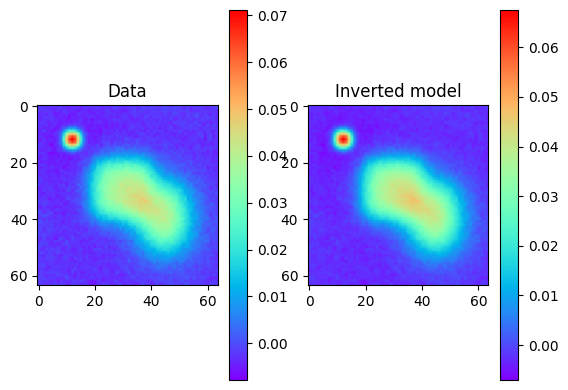

In [5]:
plt.subplot(1, 2, 1)
plt.imshow(D.view(n1, n2).cpu().detach().numpy(), cmap="rainbow")
plt.title("Data")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(pred.view(n1, n2).cpu().detach().numpy(), cmap="rainbow")
plt.title("Inverted model")
plt.colorbar()

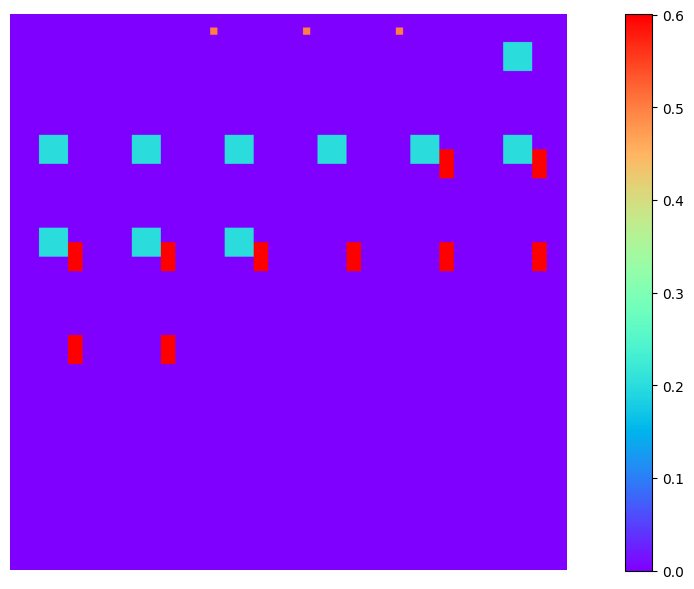

In [6]:
import ssmaginv.plot.plot as magplot

magplot.plot_model_2d(M = xtrue)

### Pyvista Plotting

Now for a 3d plot in Pyvista. Note that downward is the positive x direction in our geomodel.

https://tutorial.pyvista.org/tutorial/00_jupyter/index.html

c:\Users\sghys\miniconda3\envs\mag_inv\Lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


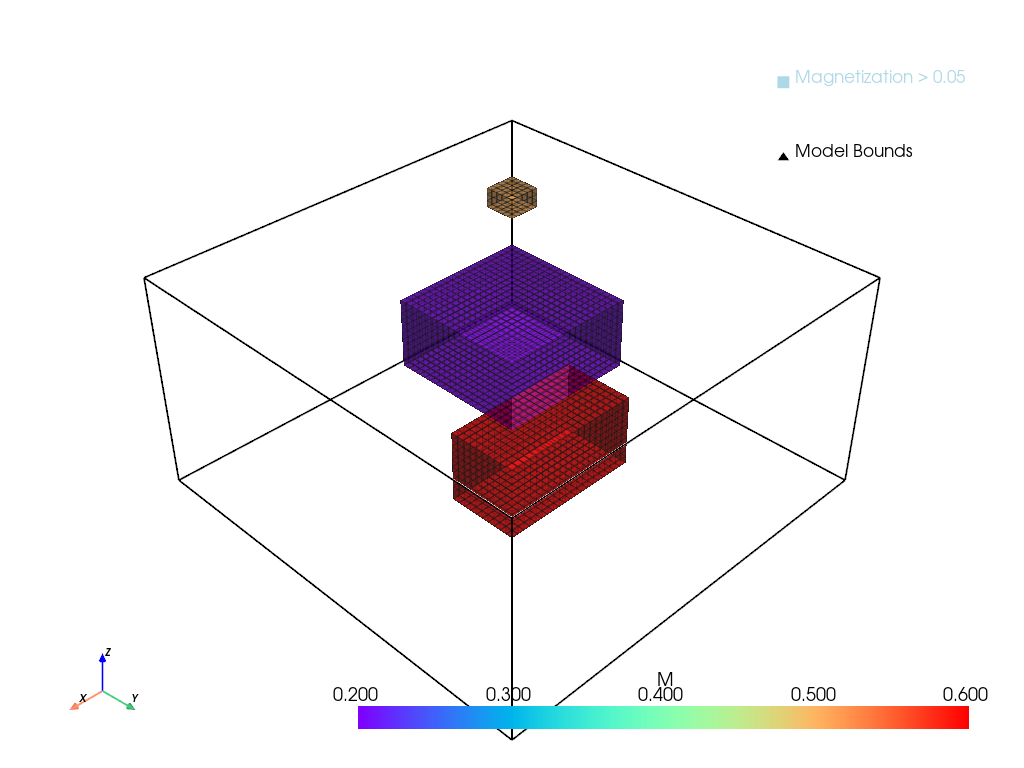

In [7]:
import pyvista as pv
# Set jupyter backend for pyvista (more info)

plotter = magplot.plot_model_3d(M = xtrue)

# Save image of the model
plotter.screenshot("3dmodel.png")

plotter.show()



### Plotting Model with Forward Data Overlay

c:\Users\sghys\miniconda3\envs\mag_inv\Lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


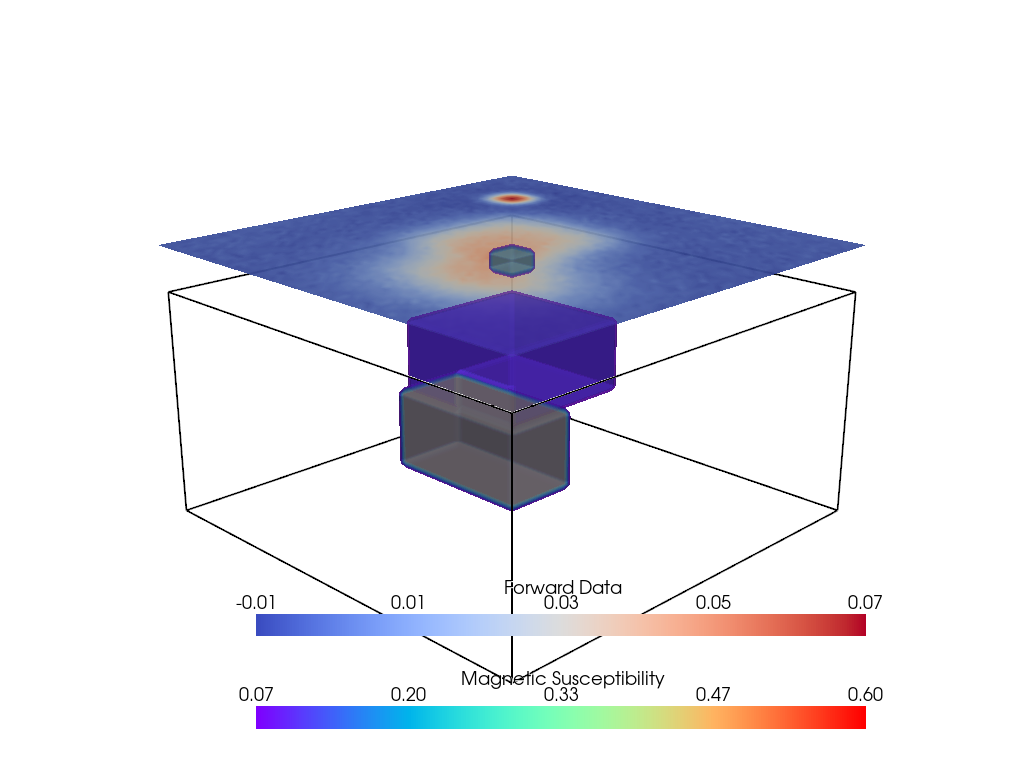

In [8]:
plotter = magplot.plot_model_with_forward(xtrue, D, spacing=h,  n_isovals=10,)
plotter.screenshot("3dforward.png")
plotter.show()

### Full comparison

The idea is to have linked 2d and 3d views of the model and forward data. The color scaling should be shared between the estimated and true model/data. Recommended to run this outside of a notebook.

c:\Users\sghys\miniconda3\envs\mag_inv\Lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


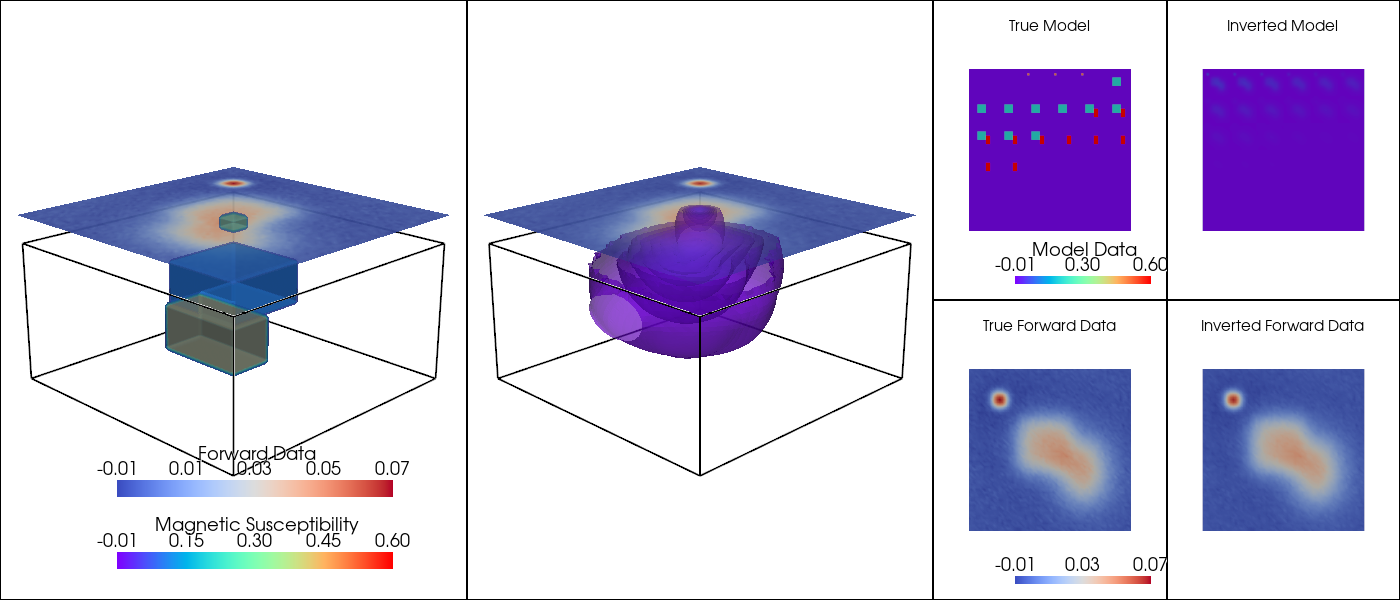

In [9]:
plotter = magplot.plot_mixed(mag_data_true=xtrue, 
                   mag_data_model=xinv, 
                   forward_data_true=D,
                   forward_data_model=pred,
                   spacing=h, n_isovals=10)
plotter.screenshot("3dmixed.png")
plotter.show()